In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [2]:
df = pd.read_json("pycharm_issues.json", lines=True)

In [3]:
interesting_versions = ["2020.2", "2020.3", "2021.1", "2021.2", "2021.3"]

def check(versions):
    for x in interesting_versions:
        if x in versions:
            return True
    return False

df = df[df["Affected versions"].apply(check)].reset_index()

In [4]:
counter = CountVectorizer(
    ngram_range=(2, 3), 
    max_df=0.2
)
X = counter.fit_transform(df["summary"])

In [5]:
n_topics = 7
lda = LDA(n_components=n_topics, random_state=339264239)
lda.fit(X)

LatentDirichletAllocation(n_components=7, random_state=339264239)

In [6]:
affected_2020_2 = X[df[df["Affected versions"].apply(lambda x: "2020.2" in x)].index, :]
affected_2020_3 = X[df[df["Affected versions"].apply(lambda x: "2020.3" in x)].index, :]

In [7]:
meaningless_words=['is not', 'are not', 'does not', 'in pycharm', 'py charm', 'of the', 'in the', 'instead of', 
    'is used', 'number of', 'not work', 'does not work', 'unable to', 'in python', 'not working', 'work on', 
    'python 10', 'fails to', 'error when', 'way to', 'to the', 'doesn work', 'if the', 'pycharm 2020', 'pycharm 2021', 'no longer',
    'when using', ]

feature_names = counter.get_feature_names_out()[np.argsort(lda.components_, axis=-1)[:, ::-1]]
docs = lda.transform(X)

for features, confidence, doc in zip(feature_names, docs.max(axis=0), df["summary"][docs.argmax(axis=0)]):
    out_features = [x for x in features if x not in meaningless_words][:5]
    print(confidence, doc, out_features)
    print() 

0.9902584576665416 When I move my project in other directory and even delete .idea  PyCharm have troubles with identifying the way to my venv interpreter. It changing this path as soon as I configure it in previous window.  (I`m creatining venv through 'python -m venv venv'). I faced with this problem before. ['false positive', 'python console', 'type inference', 'in python console', 'incorrect type']

0.9841137212990364 IDE keeps disabling Python plugin, I get and error "Unable to save plugin settings: The plugin Pythonid failed to save settings and has been disabled. Please restart IntelliJ IDEA" ['python console', 'false positive', 'not be', 'jupyter notebook', 'on windows']

0.982847093786736 Wrong type evaluation in if-else block and different attribute hints for if-else block and inline if-else when some exception can be raised before ['completion for', 'code completion', 'from the', 'no completion for', 'no completion']

0.9821375586559549 I run PyCharm Community inside or Rider

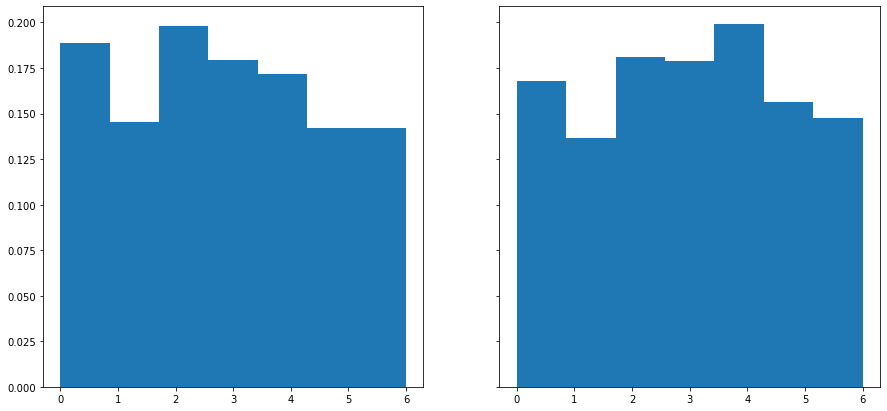

In [8]:
topics_2020_2 = lda.transform(affected_2020_2).argmax(axis=-1)
topics_2020_3 = lda.transform(affected_2020_3).argmax(axis=-1)

fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(7)

axs[0].hist(topics_2020_2, bins=n_topics, density=True)
axs[1].hist(topics_2020_3, bins=n_topics, density=True)

plt.show()